In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

Using TensorFlow backend.


In [0]:
import os
from glob import glob
os.chdir('/content/')
!rm -rf Satellite-Segmentation
!git clone https://github.com/JasonChu1313/Satellite-Segmentation.git
import os 
os.chdir('/content/Satellite-Segmentation')
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/

!kaggle competitions download -c comp-540-spring-2019
!mkdir data
!mv train.zip ./data/
!mv val.zip ./data/
os.chdir("./data")
!unzip val.zip
!unzip train.zip


Cloning into 'Satellite-Segmentation'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 332 (delta 28), reused 36 (delta 14), pack-reused 278
Receiving objects: 100% (332/332), 502.60 KiB | 6.05 MiB/s, done.
Resolving deltas: 100% (230/230), done.
 40% 9.00M/22.5M [00:00<00:00, 23.5MB/s]
100% 22.5M/22.5M [00:00<00:00, 50.8MB/s]
 99% 467M/470M [00:03<00:00, 114MB/s]
100% 470M/470M [00:03<00:00, 132MB/s]
 91% 81.0M/88.6M [00:01<00:00, 59.4MB/s]
100% 88.6M/88.6M [00:01<00:00, 67.9MB/s]
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  val.zip
   creating: val/
  inflating: val/68707_sat.jpg       
  inflating: val/68711_sat.jpg       
  inflating: val/68720_sat.jpg       
  inflating: val/68729_sat.jpg       
  inflating: val/68731_sat.jpg       
  inflating: val/68733_sat.jpg       
  inflating: val/68738_sat.jpg       
  in

1.13.0-rc2


In [0]:
from glob import glob
import os

path_to_train = './train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])

['./train/11392_sat.jpg', './train/45105_sat.jpg', './train/51399_sat.jpg', './train/41750_sat.jpg', './train/7034_sat.jpg', './train/17068_sat.jpg', './train/32335_sat.jpg', './train/10887_sat.jpg', './train/11620_sat.jpg', './train/23099_sat.jpg']
['./train/51724_msk.png', './train/32199_msk.png', './train/19410_msk.png', './train/43828_msk.png', './train/50367_msk.png', './train/15513_msk.png', './train/1944_msk.png', './train/22697_msk.png', './train/31677_msk.png', './train/7467_msk.png']


In [0]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

def get_img_id(img_path):
  img_basename = os.path.basename(img_path)
  img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
  return img_id

def img_gen(img_paths, img_size=(512, 512)):
  #Iterate over all image paths
  for img_path in img_paths:
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train,img_id+'_msk.png')
    
    img = imread(img_path)/255
    mask = rgb2gray(imread(mask_path))
    
#     img = resize(img, img_size, preserve_range = True)
#     mask = resize(mask, img_size, mode='constant', preserve_range = True)
    
    mask = (mask>=0.5).astype(float)
    mask = np.reshape(mask, (512,512,1))
    yield img, mask

In [0]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = img_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
            batch_img, batch_mask = [], []



__MACOSX  train  train.zip  val  val.zip
(512, 512, 3)


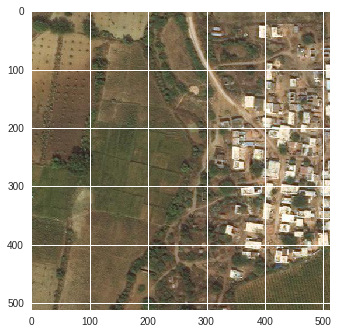

TypeError: ignored

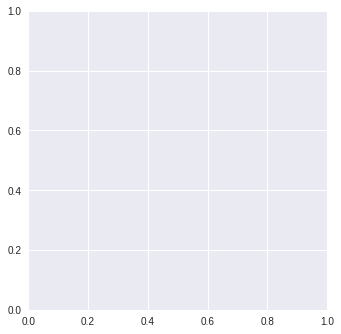

In [0]:
import matplotlib.pyplot as plt
!ls
ig = img_gen(train_img_paths)
first_img, first_mask = next(ig)
print(first_img.shape)
plt.imshow(first_img)
plt.show()
plt.imshow(first_mask, cmap='gray')
plt.show

In [0]:
from sklearn.model_selection import train_test_split

BATCHSIZE = 8

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)
print(len(train_img_paths))
print(len(val_img_paths))

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)
print(next(traingen)[0].shape)
def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)
print("train steps {}".format(train_steps))
print("val steps {}".format(val_steps))

9262
1635
(8, 512, 512, 3)
train steps 1158
val steps 205


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
  
# Build U-Net model
inputs = Input((512, 512, 3))
s = inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.4 * binary_crossentropy(y_true, y_pred) + 0.6 * dice_loss(y_true, y_pred)
  
def ln_dice(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred = K.cast(y_pred, 'float32')
  y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
  intersection = y_true_f * y_pred_f
  score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return K.log(score)

def new_bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - ln_dice(y_true, y_pred)
  

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 512, 512, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 512, 512, 16) 0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 512, 512, 16) 2320        dropout_37[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [0]:
!pip install pydrive

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# #https://drive.google.com/open?id=1WB1l16RGBPynI7PZRI7lSNEUO_C0KAt1
# keras_model = drive.CreateFile({'id':'1WB1l16RGBPynI7PZRI7lSNEUO_C0KAt1'})
# keras_model.GetContentFile('cp-0023.h5')



In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [0]:
clr = CyclicLR(base_lr=1e-4, max_lr=6e-4,
                                step_size=3000., mode='triangular2')


checkpointer = ModelCheckpoint('cp-{epoch:02d}-{val_loss:.4f}.h5', verbose=1)
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=50, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5,  # Change this number based on memory restrictions
    callbacks = [checkpointer, clr]
)


Epoch 1/50
1158/1158 [==============================] - 876s 757ms/step - loss: 0.4704 - dice_coef: 0.3531 - val_loss: 0.4101 - val_dice_coef: 0.4488

Epoch 00001: saving model to cp-01-0.4101.h5
Epoch 2/50
1158/1158 [==============================] - 876s 757ms/step - loss: 0.3669 - dice_coef: 0.5039 - val_loss: 0.3609 - val_dice_coef: 0.5195

Epoch 00002: saving model to cp-02-0.3609.h5
Epoch 3/50
1158/1158 [==============================] - 875s 755ms/step - loss: 0.3189 - dice_coef: 0.5703 - val_loss: 0.3191 - val_dice_coef: 0.5748

Epoch 00003: saving model to cp-03-0.3191.h5
Epoch 4/50
1158/1158 [==============================] - 877s 757ms/step - loss: 0.2787 - dice_coef: 0.6246 - val_loss: 0.2861 - val_dice_coef: 0.6179

Epoch 00004: saving model to cp-04-0.2861.h5
Epoch 5/50
1158/1158 [==============================] - 882s 762ms/step - loss: 0.2496 - dice_coef: 0.6640 - val_loss: 0.2480 - val_dice_coef: 0.6653

Epoch 00005: saving model to cp-05-0.2480.h5
Epoch 6/50
1158/1158

In [0]:
import pandas as pd

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")

NameError: ignored

In [0]:
# Get and resize test images

path_to_val = './val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
test_id = [get_img_id(val_img_paths[i]) for i in range(len(val_img_paths))]

def val_img_gen(val_img_paths,img_size=(512,512)):
  for i, val_img_path in enumerate(val_img_paths):
    img = imread(val_img_path)/255
    img = resize(img, img_size, preserve_range = True)
    img = np.reshape(img, (1,512,512,3))
    yield img
    

# Predict on test

model = load_model('cp-0023.h5', custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})
vig = val_img_gen(val_img_paths)

result = model.predict_generator(vig,steps = len(val_img_paths), max_queue_size=5, workers=1, use_multiprocessing=False, verbose=1)



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2169/2169 [==============================] - 157s 72ms/step


In [0]:
# Create submission DataFrame
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediction of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    #sub['Height'] = [512]*num_images Nonger needed for DICE Scoring
    #sub['Width'] = [512]*num_images Nonger needed for DICE Scoring
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() >0.5)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
  
result = np.reshape(result, (2169, 512, 512))


create_submission("sub_unet_23epo_8batch_id2.csv", result, test_id)

215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169
